In [21]:
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn
!pip install optuna-integration -q 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder,
    FunctionTransformer)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    confusion_matrix,
    recall_score,
    precision_score
)
from sklearn.compose import ColumnTransformer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer, f1_score

# импортируем классы оптимизаторы
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from optuna.integration import OptunaSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor, DummyClassifier

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные классы
from sklearn.pipeline import Pipeline

from scipy import stats as st
import scipy.stats as sps
import shap
from sklearn import tree

<h2>1. Загрузка данных</h2>


In [23]:
df_yndx = pd.read_csv("D:\Yapro\YNDX_230918_240117.csv", header=0, sep=';')

In [24]:
df_test = pd.read_csv("D:\Yapro\RTS_240120_240519.csv", header=0, sep=',')

In [25]:
df_yndx.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,YNDX,1,230918,100000,2593.0,2608.8,2590.0,2601.8,27346
1,YNDX,1,230918,100100,2601.8,2601.8,2590.0,2592.2,4102
2,YNDX,1,230918,100200,2591.0,2592.6,2587.0,2587.4,2572
3,YNDX,1,230918,100300,2587.4,2589.8,2583.0,2585.0,1643
4,YNDX,1,230918,100400,2584.2,2589.0,2584.0,2589.0,680


<h2>2. Предобработка данных</h2>

In [26]:
def data_info(data, data_name):
    print("Информация о столбцах таблицы ", data_name)
    display(data.info())
    print("Количество незаполненных значений в полях:")
    print(data.isna().sum())
    dupl = data.duplicated().sum()
    print("Количество дубликатов:", dupl)  

In [27]:
data_info(df_yndx, "Акции Яндекса")

Информация о столбцах таблицы  Акции Яндекса
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69379 entries, 0 to 69378
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  69379 non-null  object 
 1   <PER>     69379 non-null  int64  
 2   <DATE>    69379 non-null  int64  
 3   <TIME>    69379 non-null  int64  
 4   <OPEN>    69379 non-null  float64
 5   <HIGH>    69379 non-null  float64
 6   <LOW>     69379 non-null  float64
 7   <CLOSE>   69379 non-null  float64
 8   <VOL>     69379 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 4.8+ MB


None

Количество незаполненных значений в полях:
<TICKER>    0
<PER>       0
<DATE>      0
<TIME>      0
<OPEN>      0
<HIGH>      0
<LOW>       0
<CLOSE>     0
<VOL>       0
dtype: int64
Количество дубликатов: 0


In [28]:
df_yndx.columns

Index(['<TICKER>', '<PER>', '<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>',
       '<CLOSE>', '<VOL>'],
      dtype='object')

In [29]:
df_yndx.columns = ['TICKER', 'PER', 'DATE', 'TIME', 'OPEN', 'HIGH', 'LOW',
       'CLOSE', 'VOL']

</br> Выполнена предобработка данных

<h2>3. Исследовательский анализ данных</h2>

In [30]:
def numeric_exploration(data, lst_cols):
    for col in lst_cols:
        print('Статистическая информация по столбцу:', col)
        print(data[col].describe())
        plt.hist(data[col])
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.grid(True)
        plt.title('Гистограмма частот по признаку ' + col)
        plt.show()        
        data.boxplot(column=col, vert=False)
        plt.xlabel(col)
        plt.grid(True)
        plt.title('Распределение по квартилям (ящик с усами) для признака ' + col)
        plt.show()

Статистическая информация по столбцу: CLOSE
count    69379.000000
mean      2506.449710
std        134.138338
min       2118.400000
25%       2405.200000
50%       2543.200000
75%       2609.200000
max       2770.800000
Name: CLOSE, dtype: float64


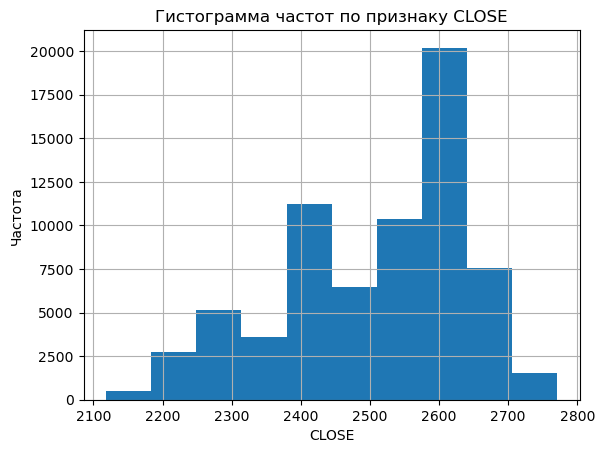

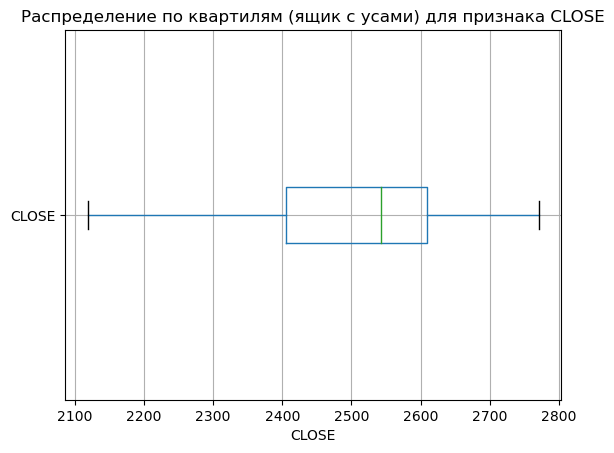

In [31]:
numeric_exploration(df_yndx,['CLOSE'])

In [32]:
df_yndx['FULL_DATE'] = df_yndx['DATE'].astype("str") + "T" + df_yndx['TIME'].astype("str")
df_yndx['FULL_DATE'] = pd.to_datetime(   
    df_yndx['FULL_DATE'], format='%y%m%dT%H%M%S'
)

In [33]:
df_yndx=df_yndx.drop(['TICKER', 'PER', 'DATE', 'TIME'], axis = 1)

In [34]:
data_info(df_yndx, "Акции Яндекса")

Информация о столбцах таблицы  Акции Яндекса
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69379 entries, 0 to 69378
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   OPEN       69379 non-null  float64       
 1   HIGH       69379 non-null  float64       
 2   LOW        69379 non-null  float64       
 3   CLOSE      69379 non-null  float64       
 4   VOL        69379 non-null  int64         
 5   FULL_DATE  69379 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 3.2 MB


None

Количество незаполненных значений в полях:
OPEN         0
HIGH         0
LOW          0
CLOSE        0
VOL          0
FULL_DATE    0
dtype: int64
Количество дубликатов: 0


In [35]:
def fill_next_step(df):
    df['NEXT_VAL'] = df['NEXT_CLOSE'] - df['CLOSE']
    df['NEXT_VAL'] = df['NEXT_VAL'].apply(lambda x: 1 if x >= 0 else -1)
    return df

In [36]:
df_yndx['NEXT_CLOSE'] = df_yndx['CLOSE'].shift(-1)

In [37]:
df_yndx = fill_next_step(df_yndx)

In [38]:
df_yndx.head()

,OPEN,HIGH,LOW,CLOSE,VOL,FULL_DATE,NEXT_CLOSE,NEXT_VAL
0,2593.0,2608.8,2590.0,2601.8,27346,2023-09-18 10:00:00,2592.2,-1
1,2601.8,2601.8,2590.0,2592.2,4102,2023-09-18 10:01:00,2587.4,-1
2,2591.0,2592.6,2587.0,2587.4,2572,2023-09-18 10:02:00,2585.0,-1
3,2587.4,2589.8,2583.0,2585.0,1643,2023-09-18 10:03:00,2589.0,1
4,2584.2,2589.0,2584.0,2589.0,680,2023-09-18 10:04:00,2587.6,-1


In [39]:
def rsi(df, window_length):
    df = pd.DataFrame(df)
    df['diff'] = df.diff(1)
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    
    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] = \
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] = \
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1]) \
            / window_length
    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    return df['rsi']

In [40]:
df_yndx['rsi'] = rsi(df_yndx['CLOSE'], 5)

In [41]:
df_yndx.head(-5)

,OPEN,HIGH,LOW,CLOSE,VOL,FULL_DATE,NEXT_CLOSE,NEXT_VAL,rsi
0,2593.0,2608.8,2590.0,2601.8,27346,2023-09-18 10:00:00,2592.2,-1,NaN
1,2601.8,2601.8,2590.0,2592.2,4102,2023-09-18 10:01:00,2587.4,-1,NaN
2,2591.0,2592.6,2587.0,2587.4,2572,2023-09-18 10:02:00,2585.0,-1,NaN
3,2587.4,2589.8,2583.0,2585.0,1643,2023-09-18 10:03:00,2589.0,1,NaN
4,2584.2,2589.0,2584.0,2589.0,680,2023-09-18 10:04:00,2587.6,-1,NaN
...,...,...,...,...,...,...,...,...,...
69369,2652.2,2652.4,2652.2,2652.2,78,2024-01-17 23:40:00,2652.2,1,55.491114
69370,2652.2,2652.2,2652.2,2652.2,70,2024-01-17 23:41:00,2652.4,1,55.491114
69371,2652.4,2652.4,2652.2,2652.4,56,2024-01-17 23:42:00,2652.4,1,65.977815
69372,2652.4,2652.4,2652.2,2652.4,260,2024-01-17 23:43:00,2652.4,1,65.977815


In [42]:
def mfi(df, n=14):
    typical_price = (df['HIGH'] + df['LOW'] + df['CLOSE']) / 3
    money_flow = typical_price * df['VOL']
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign

    # Calculate gain and loss using vectorized operations
    positive_mf = np.where(signed_mf > 0, signed_mf, 0)
    negative_mf = np.where(signed_mf < 0, -signed_mf, 0)

    mf_avg_gain = pd.Series(positive_mf).rolling(n, min_periods=1).sum()
    mf_avg_loss = pd.Series(negative_mf).rolling(n, min_periods=1).sum()
    
    return pd.Series((100 - 100 / (1 + mf_avg_gain / mf_avg_loss)).to_numpy())


In [43]:
def atr(df, n=14):
    tr = np.amax(np.vstack(((df['HIGH'] - df['LOW']).to_numpy(),\
                            (abs(df['HIGH'] - df['CLOSE'])).to_numpy(), (abs(df['LOW'] - df['CLOSE'])).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean()

In [44]:
def Bollindger(df, n=14):
    df["SMA_n"] = df["CLOSE"].rolling(window=n).mean()
    q = 0
    for s in df["SMA_n"]:
        if (q >= n):
            df.loc[q, "std"] = np.std(df.loc[-n + q:q, "CLOSE"], ddof=1)
        q = q + 1
    df["bb_high"] = df["SMA_n"] + 2 * df["std"]
    df["bb_low"] = df["SMA_n"] - 2 * df["std"]
    return df

In [45]:
df_yndx = Bollindger(df_yndx)

In [46]:
def Signal_Bollindger(df):
    df['bbh'] = (df['HIGH'] >= df["bb_high"]) & (df['LOW'] >= df["bb_low"])
    #df['bbh'] = df['bbh'].apply(lambda x: 1 if x == True else 0)
    
    df['bbl'] = (df['HIGH'] <= df["bb_high"]) & (df['LOW'] <= df["bb_low"])
    #df['bbl'] = df['bbl'].apply(lambda x: 1 if x == True else 0)
    
    q = 0
    z = 0
    for p in df['CLOSE']:
        if (df.loc[q,'bbh'] == True):
            z = 1
        elif (df.loc[q,'bbl'] == True):
            z = -1
        df.loc[q,'bb'] = z
        q = q + 1
    df = df.drop(['bb_high', 'bb_low', 'SMA_n', 'std','bbh','bbl'], axis=1)
    return df

In [47]:
df_yndx = Signal_Bollindger(df_yndx)

In [48]:
df_yndx

,OPEN,HIGH,LOW,CLOSE,VOL,FULL_DATE,NEXT_CLOSE,NEXT_VAL,rsi,bb
0,2593.0,2608.8,2590.0,2601.8,27346,2023-09-18 10:00:00,2592.2,-1,NaN,0.0
1,2601.8,2601.8,2590.0,2592.2,4102,2023-09-18 10:01:00,2587.4,-1,NaN,0.0
2,2591.0,2592.6,2587.0,2587.4,2572,2023-09-18 10:02:00,2585.0,-1,NaN,0.0
3,2587.4,2589.8,2583.0,2585.0,1643,2023-09-18 10:03:00,2589.0,1,NaN,0.0
4,2584.2,2589.0,2584.0,2589.0,680,2023-09-18 10:04:00,2587.6,-1,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
69374,2652.2,2652.2,2652.0,2652.0,202,2024-01-17 23:45:00,2652.0,1,34.357214,1.0
69375,2652.0,2652.2,2652.0,2652.0,117,2024-01-17 23:46:00,2652.2,1,34.357214,1.0
69376,2652.0,2652.2,2652.0,2652.2,8,2024-01-17 23:47:00,2652.0,-1,52.239741,1.0
69377,2652.0,2652.2,2652.0,2652.0,112,2024-01-17 23:48:00,2652.4,1,38.969547,1.0


In [49]:
df_yndx.loc[(df_yndx['bb'] == 1)]

,OPEN,HIGH,LOW,CLOSE,VOL,FULL_DATE,NEXT_CLOSE,NEXT_VAL,rsi,bb
70,2600.8,2601.2,2597.4,2598.4,2052,2023-09-18 11:10:00,2598.4,1,53.720263,1.0
71,2600.0,2600.0,2596.4,2598.4,1063,2023-09-18 11:11:00,2601.6,1,53.720263,1.0
72,2597.8,2601.6,2597.4,2601.6,843,2023-09-18 11:12:00,2599.8,-1,70.399113,1.0
73,2601.0,2601.4,2599.8,2599.8,730,2023-09-18 11:13:00,2599.2,-1,56.166487,1.0
74,2600.0,2602.8,2599.2,2599.2,1808,2023-09-18 11:14:00,2599.6,1,51.802742,1.0
...,...,...,...,...,...,...,...,...,...,...
69374,2652.2,2652.2,2652.0,2652.0,202,2024-01-17 23:45:00,2652.0,1,34.357214,1.0
69375,2652.0,2652.2,2652.0,2652.0,117,2024-01-17 23:46:00,2652.2,1,34.357214,1.0
69376,2652.0,2652.2,2652.0,2652.2,8,2024-01-17 23:47:00,2652.0,-1,52.239741,1.0
69377,2652.0,2652.2,2652.0,2652.0,112,2024-01-17 23:48:00,2652.4,1,38.969547,1.0


In [50]:
mfi(df_yndx)

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         1.863454
           ...    
69374    37.004298
69375    39.896491
69376    39.896505
69377    31.467132
69378    48.157936
Length: 69379, dtype: float64

In [51]:
def mg(x):
    if x > 70:
        return 1
    if x < 30:
        return -1
    return 0

In [52]:
df_yndx['mfi'] = mfi(df_yndx)

In [53]:
df_yndx['atr'] = atr(df_yndx)

In [54]:
df_yndx['hr'] = df_yndx['FULL_DATE'].dt.hour

In [55]:
df_yndx.head(-10)

,OPEN,HIGH,LOW,CLOSE,VOL,FULL_DATE,NEXT_CLOSE,NEXT_VAL,rsi,bb,mfi,atr,hr
0,2593.0,2608.8,2590.0,2601.8,27346,2023-09-18 10:00:00,2592.2,-1,NaN,0.0,0.000000,NaN,10
1,2601.8,2601.8,2590.0,2592.2,4102,2023-09-18 10:01:00,2587.4,-1,NaN,0.0,0.000000,NaN,10
2,2591.0,2592.6,2587.0,2587.4,2572,2023-09-18 10:02:00,2585.0,-1,NaN,0.0,0.000000,NaN,10
3,2587.4,2589.8,2583.0,2585.0,1643,2023-09-18 10:03:00,2589.0,1,NaN,0.0,0.000000,NaN,10
4,2584.2,2589.0,2584.0,2589.0,680,2023-09-18 10:04:00,2587.6,-1,NaN,0.0,1.863454,NaN,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69364,2652.0,2652.2,2652.0,2652.2,53,2024-01-17 23:35:00,2652.0,-1,66.236665,1.0,88.412090,0.571429,23
69365,2652.2,2652.2,2652.0,2652.0,139,2024-01-17 23:36:00,2652.2,1,56.936614,1.0,84.715222,0.585714,23
69366,2652.2,2652.2,2652.0,2652.2,41,2024-01-17 23:37:00,2652.4,1,63.366148,1.0,84.602220,0.585714,23
69367,2652.2,2652.4,2652.2,2652.4,423,2024-01-17 23:38:00,2652.4,1,69.127821,1.0,85.105710,0.585714,23


In [56]:
M2 = df_yndx.drop("FULL_DATE", axis=1).phik_matrix(interval_cols=['OPEN','HIGH','LOW','CLOSE','VOL','IND', 
                                                                   'rsi', 'NEXT_CLOSE', 'mfi', 'atr', 'hr'])
display(M2)

,OPEN,HIGH,LOW,CLOSE,VOL,NEXT_CLOSE,NEXT_VAL,rsi,bb,mfi,atr,hr
OPEN,1.000000,0.999046,0.999544,0.999915,0.042557,0.999810,0.033851,0.076078,0.052938,0.103488,0.191400,0.129548
HIGH,0.999046,1.000000,0.997822,0.999016,0.044374,0.998881,0.035997,0.081025,0.055035,0.112317,0.189055,0.143036
LOW,0.999544,0.997822,1.000000,0.999628,0.049343,0.999501,0.031766,0.084549,0.055031,0.100031,0.196464,0.117997
CLOSE,0.999915,0.999016,0.999628,1.000000,0.043285,0.999913,0.036005,0.082033,0.053433,0.106044,0.191202,0.129370
VOL,0.042557,0.044374,0.049343,0.043285,1.000000,0.041942,0.008400,0.159657,0.022337,0.068501,0.408927,0.062923
NEXT_CLOSE,0.999810,0.998881,0.999501,0.999913,0.041942,1.000000,0.023004,0.080836,0.053079,0.104644,0.191512,0.129513
NEXT_VAL,0.033851,0.035997,0.031766,0.036005,0.008400,0.023004,1.000000,0.121675,0.011375,0.046698,0.054272,0.065767
rsi,0.076078,0.081025,0.084549,0.082033,0.159657,0.080836,0.121675,1.000000,0.450246,0.562854,0.047642,0.065890
bb,0.052938,0.055035,0.055031,0.053433,0.022337,0.053079,0.011375,0.450246,1.000000,0.552290,0.074240,0.077736
mfi,0.103488,0.112317,0.100031,0.106044,0.068501,0.104644,0.046698,0.562854,0.552290,1.000000,0.082778,0.145835


In [57]:
RANDOM_STATE=42

In [58]:
df_yndx = df_yndx.dropna()

In [59]:
df_len = df_yndx['OPEN'].count()
gr_len = round(df_len*0.75)
X_train_full = df_yndx.loc[:gr_len,['rsi', 'mfi', 'atr', 'hr','bb', 'CLOSE', 'NEXT_CLOSE']]
X_train = df_yndx.loc[:gr_len,['rsi', 'mfi', 'atr', 'hr','bb']]
y_train = df_yndx.loc[:gr_len,['NEXT_VAL']]
X_test_full = df_yndx.loc[gr_len:,['rsi', 'mfi', 'atr', 'hr','bb', 'CLOSE', 'NEXT_CLOSE']]
X_test = df_yndx.loc[gr_len:,['rsi', 'mfi', 'atr', 'hr','bb']]
y_test = df_yndx.loc[gr_len:,['NEXT_VAL']]


In [60]:
# создаём списки с названиями признаков
#ohe_columns = [ 'last_year_promo', 'last_year_violations', 'dept', 'supervisor_evaluation']
#ord_columns = ['rsi2', 'hr']
num_columns = ['hr','rsi','mfi', 'atr','bb']

In [61]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
    )


ord_pipe = Pipeline(
    [
    ('ord', OrdinalEncoder(categories=[
        ['-1', '1'],
        ['low', 'medium', 'high']
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
      ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     ]
)

num_pipe = Pipeline(
    [('sc', MinMaxScaler()),
     ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean'))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [#('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

<h2>3. Проноз</h2>

In [62]:
# создаём функцию для оценки качества модели

def profit(y_true, y_pred, X):
    X = X.reset_index()
    proc = 0.00015
    metric = (X['NEXT_CLOSE'] - X['CLOSE']) * y_pred
    y_prev = y_pred[0]
    com = proc * X.loc[0,'CLOSE']
    q = 1
    for y in y_pred:
        if y != y_prev:
            com = com + proc * X.loc[q-1,'CLOSE'] * 2                       
            y_prev = y        
        q = q + 1     
    return metric.sum() - com

def profit2(y_true, y_pred, X):
    X = X.reset_index()
    proc = 0.00015
    q = 0
    stavka = 0
    com = 0
    for x in X['CLOSE']:
        if (q != 0):
            com += X.loc[q, 'CLOSE'] * proc * stavka
        stavka = y_pred[q]
        com += X.loc[q, 'CLOSE'] * proc * stavka
        q += 1
        
    metric = (X['NEXT_CLOSE'] - X['CLOSE']) * y_pred   
    
    return metric.sum() - com

def profit_nocom(y_true, y_pred, X):
    X = X.reset_index()
    proc = 0
    metric = (X['NEXT_CLOSE'] - X['CLOSE']) * y_pred  
    print(metric)
    return metric.sum()

# создаём пользовательскую метрику
#scorer = make_scorer(profit, greater_is_better = False, x_close=X_train['CLOSE'] )

In [63]:
param_grid = [
     # словарь для модели DecisionTreeRegressor()
#     {
#         'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
#         'models__max_depth': range(5,20),
#         'models__max_features': range(5,20),
#         'models__min_samples_leaf': range(1,5),
#         'preprocessor__num': [ MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
#     },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [ MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    }
]

In [64]:
X_train_scalled = num_pipe.fit_transform(X_train)
X_test_scalled = num_pipe.transform(X_test)

In [65]:
y_train.shape

(52012, 1)

In [66]:
type(y_train['NEXT_VAL'])

pandas.core.series.Series

In [67]:
clf = DecisionTreeClassifier(max_depth = 10, max_features = 10)
#clf = KNeighborsClassifier(n_neighbors=80) 
#clf = LogisticRegression()
clf = clf.fit(X_train_scalled, y_train['NEXT_VAL'])

In [68]:
y_train_pred_ = clf.predict_proba(X_train_scalled)
y_test_pred_ = clf.predict_proba(X_test_scalled)

In [69]:
score_train = roc_auc_score(y_train, y_train_pred_[:, 1])
print(score_train)
score_test = roc_auc_score(y_test, y_test_pred_[:, 1])
print(score_test)

0.6201447193544801
0.5508418166743593


In [70]:
y_train_pred = clf.predict(X_train_scalled)
y_test_pred = clf.predict(X_test_scalled)

In [71]:
X_train_full.head()

,rsi,mfi,atr,hr,bb,CLOSE,NEXT_CLOSE
13,65.131336,37.745208,6.900000,10,0.0,2606.4,2613.0
14,77.832860,73.313971,6.200000,10,0.0,2613.0,2615.0
15,80.520627,84.908852,5.757143,10,0.0,2615.0,2615.0
16,80.520627,92.483090,5.714286,10,0.0,2615.0,2614.0
17,73.553184,91.504463,5.628571,10,0.0,2614.0,2610.8


In [72]:
y_train_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [73]:
print("Профит на тренировочной выборке с комиссией:", profit(y_train, y_train_pred, X_train_full))


Профит на тренировочной выборке с комиссией: -701.2770600000772


In [74]:
print("Профит на тестовой выборке с комиссией:", profit(y_test, y_test_pred, X_test_full))

Профит на тестовой выборке с комиссией: -826.230930000005


In [75]:
print("Профит на тренировочной выборке без комиссии:", profit_nocom(y_train, y_train_pred, X_train_full))
print("Профит на тестовой выборке без комиссии:", profit_nocom(y_test, y_test_pred, X_test_full))

0        6.6
1        2.0
2        0.0
3       -1.0
4        3.2
        ... 
52007   -0.0
52008   -0.0
52009    0.0
52010    0.0
52011    0.0
Length: 52012, dtype: float64
Профит на тренировочной выборке без комиссии: 3457.8000000000134
0        0.0
1       -0.2
2        0.2
3        0.0
4        0.0
        ... 
17349   -0.4
17350    0.0
17351    0.2
17352   -0.2
17353    0.4
Length: 17354, dtype: float64
Профит на тестовой выборке без комиссии: 538.1999999999912


In [76]:
#text_representation = tree.export_text(clf)
#print(text_representation)

In [77]:
X_train_scalled = pd.DataFrame(X_train_scalled)
X_train_scalled.columns = X_train.columns
X_test_scalled = pd.DataFrame(X_test_scalled)
X_test_scalled.columns = X_test.columns

In [78]:
f = lambda x: clf.predict_proba(x)[:,1]
med = X_train_scalled.median().values.reshape((1,X_train_scalled.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values_norm = explainer.shap_values(X_test_scalled)

  0%|          | 0/17354 [00:00<?, ?it/s]

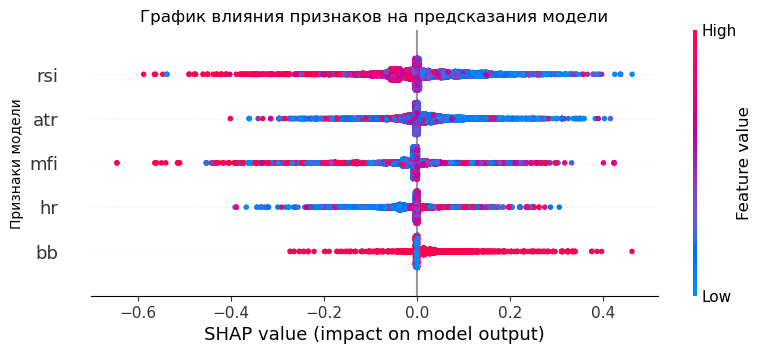

In [79]:
shap.summary_plot(shap_values_norm, X_test_scalled, feature_names=X_train_scalled.columns, \
                 title="kcgkh", show=False)
plt.ylabel('Признаки модели')
plt.title("График влияния признаков на предсказания модели")
plt.show()

<br/> Проведен прогноз